# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 14/06/2024</small></i></div>

Este notebook tiene como objetivo la definición de la última fase del modelo de difusión, es decir, el entrenamiento un modelo DDPM.

Para ello, este notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Carga del dataset](#-1.-Carga-del-dataset)

- [2. Modelo](#-2.-Modelo)

  - [2.1. Entrenamiento](#21-entrenamiento)
  - [2.2 Evaluación del modelo](#22-evaluación-del-modelo)
  - [2.3 Resultados y guardado del modelo](#23-resultados-y-guardado-del-modelo)

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()``. Para implementar el training se ha usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido la funcionalidad extra que permiten guardar cada 100 epochs los pesos del modelo en un fichero con extensión `.weights.h5`. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo o para comparar la generación de muestras a lo largo del entrenamiento, entre otras cosas. Además, también se añade la posibilidad de, cada N epochs (siendo N un número determinado por el usuario), hacer una muestra donde se plotea el proceso de sampling desde $t = T$ hasta $t = 0$ y siempre partiendo desde el mismo ruido, todo ello, para ver como evoluciona el entrenamiento a lo largo de los epochs.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Este proceso de guardado se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde mas o menos se quedó sin problemas.
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
>
> Para más información: `src/model/model_callbacks`.
</small></i>

# 0. Imports

Una vez introducido el objetivo de este notebook, se importan las librerías necesarias para el desarrollo del apartado.

---

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-07-12 01:49:49.428095: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 01:49:49.458708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 01:49:50.675871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 01:49:50.679497: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Carga del dataset

En este apartado, se cargará el dataset que se usará para entrenar el modelo de difusión. En este caso, se usará el tf.data.Dataset creado en los notebooks anteriores. Pero con la ligera diferencia de que esta vez dividiremos dicho dataset en train y test para posteriormente al entreno del modelo evaluarlo usando el conjunto de test para garantizar el buen entrenamiento del modelo de difusión.

---

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


2024-07-12 01:49:51.499732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-07-12 01:49:51.673933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Train size: 3840 sprites
- Test size: 128 sprites


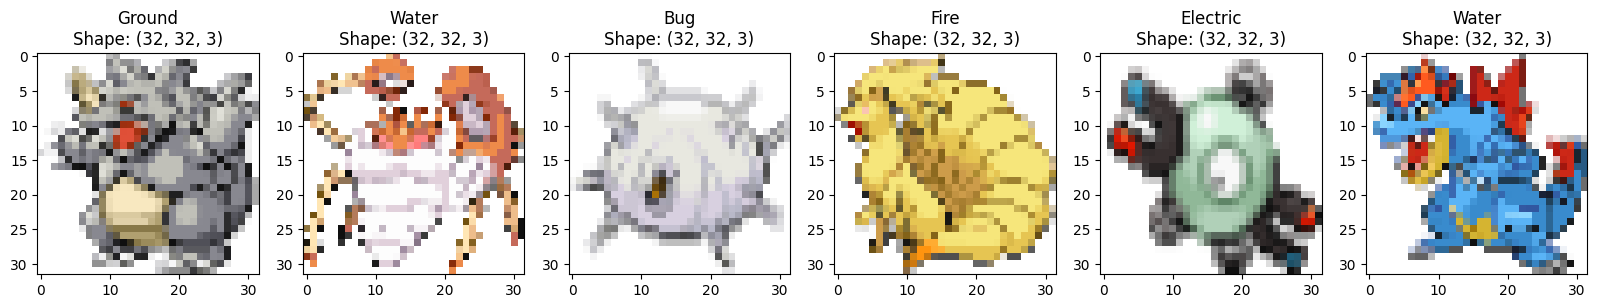

2024-07-12 01:49:52.475688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


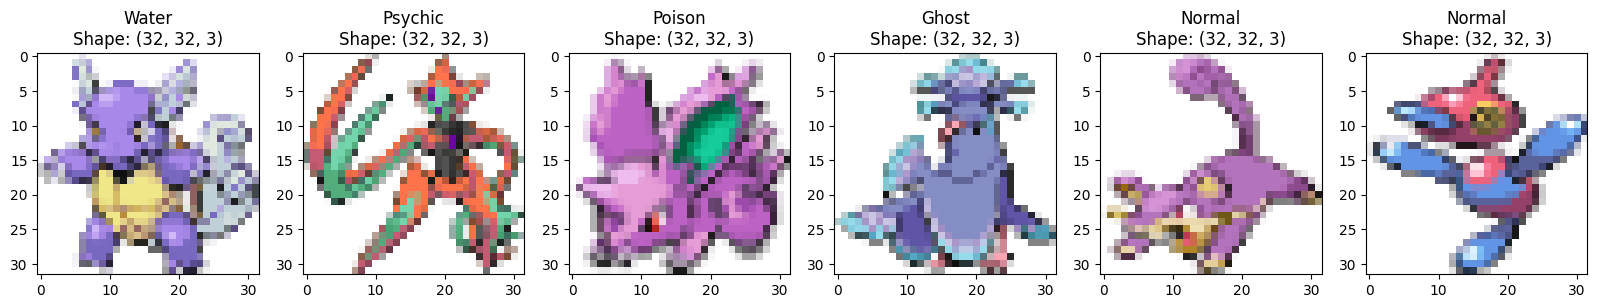

2024-07-12 01:49:52.718940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# train test split
# =====================================================================
train_poke_dataset, test_poke_dataset = tf.keras.utils.split_dataset(
    poke_dataset, left_size=0.96, shuffle=True
)

# Length of the datasets
print(f"- Train size: {len(train_poke_dataset) * BATCH_SIZE} sprites")
print(f"- Test size: {len(test_poke_dataset) * BATCH_SIZE} sprites")

# Plot
visualize.plot_images_batch(train_poke_dataset, 6)
visualize.plot_images_batch(test_poke_dataset, 6)

# 2. Modelo

Definimos el modelo usando la arquitectura **U-Net** y añadiendo las funcionalidades de un modelo de difusión con la clase `DiffusionModel()`. Además, se usa un modelo EMA (Exponential Moving Average) con el objetivo de mejorar el entrenamiento del modelo.

**Beneficios del EMA (Exponential Moving Average)**

1. **Estabilidad en la Predicción:** Las actualizaciones de los pesos de la red durante el entrenamiento pueden ser ruidosas y llevar a oscilaciones que afecten la estabilidad del modelo. Usar EMA de los pesos ayuda a suavizar estos cambios, resultando en una versión de los pesos que cambia más gradualmente y de manera más estable.

2. **Mejora en la Generalización:** Los pesos suavizados mediante EMA tienden a generalizar mejor en datos nuevos, lo que puede llevar a un mejor rendimiento en el conjunto de validación o de prueba. Esto se debe a que el EMA actúa como una forma de regularización, evitando que el modelo se ajuste demasiado a las fluctuaciones en el conjunto de datos de entrenamiento.

3. **Robustez ante el Ruido:** Al incorporar la historia de los pesos pasados de una manera suavizada, el EMA hace que la red sea menos sensible a actualizaciones ruidosas o gradientes espurios que pueden ocurrir durante el entrenamiento.

---

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.0)
ema_u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.0) # EMA model for smoother training
ema_u_net.set_weights(u_net.get_weights()) # Initialize EMA model with the same weights

model = DiffusionModel(
    model=u_net,
    ema_model=ema_u_net,
    img_size=IMG_SIZE,
    num_classes=NUM_CLASSES,
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    s=S,
    scheduler=SCHEDULER,
    ema=0.999
)

# Compile the model
# =====================================================================
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Entrenamiento

Entrenamos el modelo con los `EPOCHS` definido como hiperparámetro en el `config.ini` y añadimos la funcionalidad de guardado y muestreo de imágenes durante el entrenamiento a través del callback `DiffusionCallback`.

Epoch 1/500


/home/pqlza/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma'

 1/30 ━━━━━━━━━━━━━━━━━━━━ 23:41 49s/step - mae: 1.2199 - loss: 2.3513

I0000 00:00:1720749043.444255  152074 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_92', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1720749043.472868  152074 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - mae: 0.8866 - loss: 1.2980

I0000 00:00:1720749048.863369  153200 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 172 bytes spill stores, 172 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 255ms/step - mae: 0.8820 - loss: 1.2859 - val_loss: 0.5909 - val_mae: 0.6020
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.5415 - loss: 0.4913 - val_loss: 0.3532 - val_mae: 0.4483
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.4498 - loss: 0.3593 - val_loss: 0.3098 - val_mae: 0.4151
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.4069 - loss: 0.3038 - val_loss: 0.2709 - val_mae: 0.3791
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.3831 - loss: 0.2745 - val_loss: 0.2649 - val_mae: 0.3765
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - mae: 0.3601 - loss: 0.2470 - val_loss: 0.1985 - val_mae: 0.3239
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.3527 - loss: 0.2410 - val_loss: 0.2599 - val_mae: 0.3645
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.3396 - loss: 0.2277 - val_loss: 0.2378 - val_mae: 0.3473
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae:

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.74it/s]


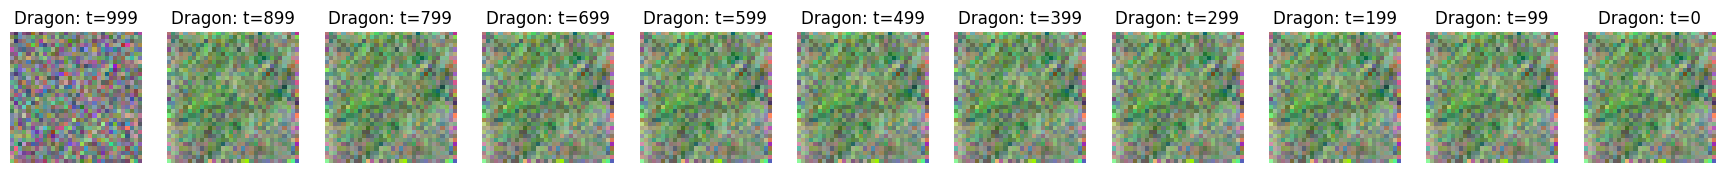

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.2531 - loss: 0.1473 - val_loss: 0.1426 - val_mae: 0.2472
Epoch 26/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.2546 - loss: 0.1504 - val_loss: 0.1390 - val_mae: 0.2437
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.2535 - loss: 0.1493 - val_loss: 0.1625 - val_mae: 0.2593
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.2510 - loss: 0.1468 - val_loss: 0.1633 - val_mae: 0.2662
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2444 - loss: 0.1406 - val_loss: 0.1369 - val_mae: 0.2426
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2485 - loss: 0.1470 - val_loss: 0.1357 - val_mae: 0.2418
Epoch 31/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2419 - loss: 0.1387 - val_loss: 0.1308 - val_mae: 0.2350
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2411 - loss: 0.1381 - val_loss: 0.1582 - val_mae: 0.2531
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step -

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.76it/s]


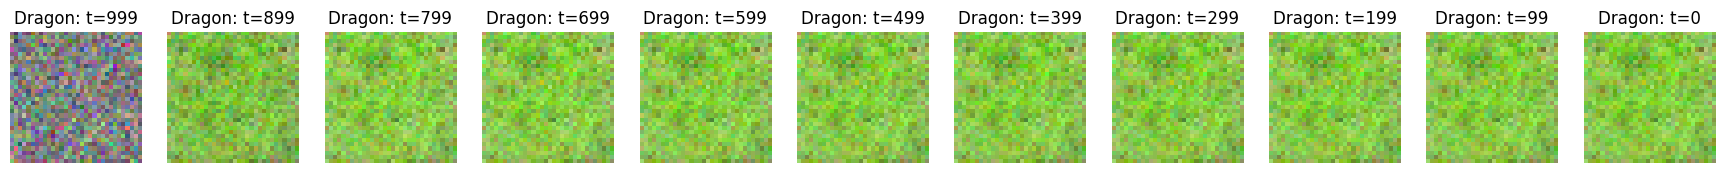

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.2248 - loss: 0.1271 - val_loss: 0.1335 - val_mae: 0.2309
Epoch 51/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2248 - loss: 0.1273 - val_loss: 0.1227 - val_mae: 0.2172
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2249 - loss: 0.1275 - val_loss: 0.1033 - val_mae: 0.2067
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2216 - loss: 0.1242 - val_loss: 0.1276 - val_mae: 0.2233
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2232 - loss: 0.1268 - val_loss: 0.1074 - val_mae: 0.2055
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2215 - loss: 0.1254 - val_loss: 0.1236 - val_mae: 0.2220
Epoch 56/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2214 - loss: 0.1255 - val_loss: 0.1238 - val_mae: 0.2224
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2212 - loss: 0.1258 - val_loss: 0.1378 - val_mae: 0.2340
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step -

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.86it/s]


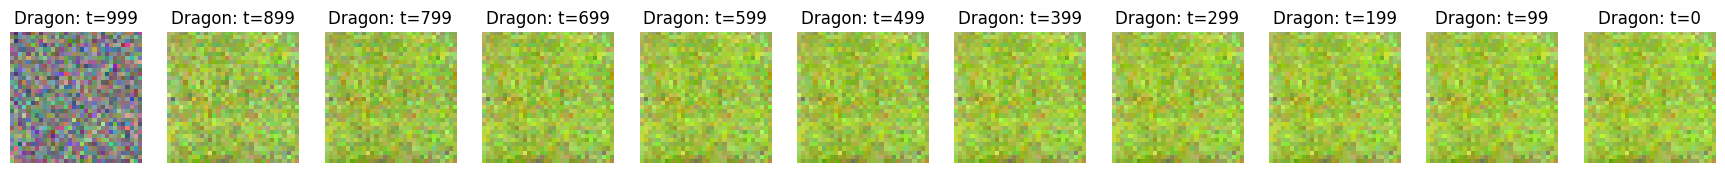

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.2139 - loss: 0.1210 - val_loss: 0.1083 - val_mae: 0.2074
Epoch 76/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2086 - loss: 0.1155 - val_loss: 0.1337 - val_mae: 0.2248
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2163 - loss: 0.1236 - val_loss: 0.1248 - val_mae: 0.2189
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2169 - loss: 0.1233 - val_loss: 0.1155 - val_mae: 0.2058
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2121 - loss: 0.1189 - val_loss: 0.1039 - val_mae: 0.1988
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2105 - loss: 0.1171 - val_loss: 0.1190 - val_mae: 0.2101
Epoch 81/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2123 - loss: 0.1193 - val_loss: 0.1133 - val_mae: 0.2107
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2100 - loss: 0.1174 - val_loss: 0.1157 - val_mae: 0.2108
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step -

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.88it/s]


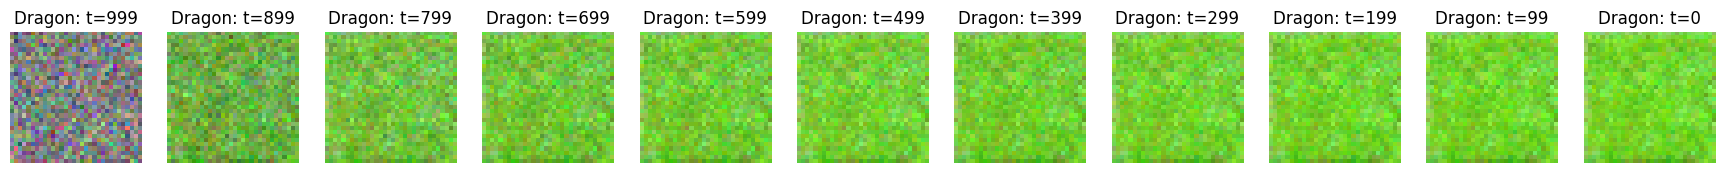

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.2012 - loss: 0.1103 - val_loss: 0.1097 - val_mae: 0.1992
Epoch 101/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2044 - loss: 0.1126 - val_loss: 0.1050 - val_mae: 0.1990
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2038 - loss: 0.1124 - val_loss: 0.1056 - val_mae: 0.1998
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2020 - loss: 0.1110 - val_loss: 0.1217 - val_mae: 0.2115
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2029 - loss: 0.1117 - val_loss: 0.1056 - val_mae: 0.1993
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2058 - loss: 0.1149 - val_loss: 0.1122 - val_mae: 0.2093
Epoch 106/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2014 - loss: 0.1095 - val_loss: 0.1217 - val_mae: 0.2102
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2005 - loss: 0.1100 - val_loss: 0.1052 - val_mae: 0.1997
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114m

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.84it/s]


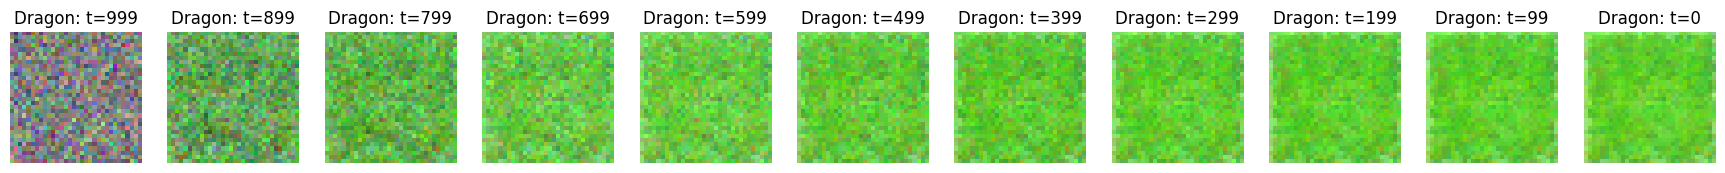

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.2003 - loss: 0.1090 - val_loss: 0.0970 - val_mae: 0.1904
Epoch 126/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.1987 - loss: 0.1080 - val_loss: 0.1048 - val_mae: 0.1939
Epoch 127/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1974 - loss: 0.1073 - val_loss: 0.1105 - val_mae: 0.2000
Epoch 128/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2008 - loss: 0.1114 - val_loss: 0.1147 - val_mae: 0.2093
Epoch 129/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1957 - loss: 0.1060 - val_loss: 0.1277 - val_mae: 0.2183
Epoch 130/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1985 - loss: 0.1083 - val_loss: 0.1309 - val_mae: 0.2168
Epoch 131/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1938 - loss: 0.1043 - val_loss: 0.1017 - val_mae: 0.1919
Epoch 132/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1996 - loss: 0.1111 - val_loss: 0.1068 - val_mae: 0.1944
Epoch 133/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113m

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.80it/s]


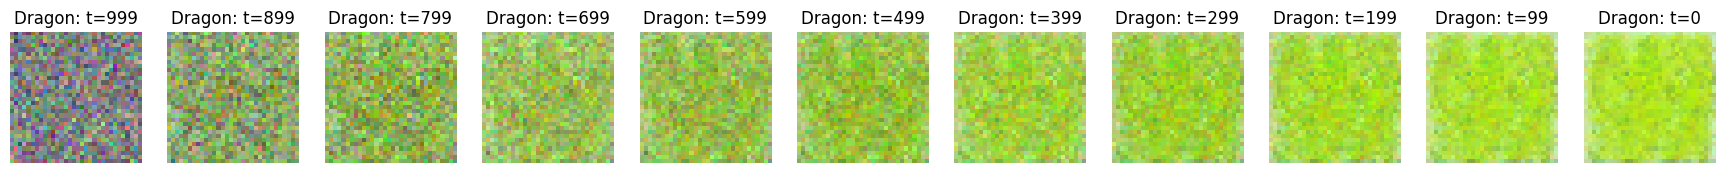

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.1968 - loss: 0.1068 - val_loss: 0.1034 - val_mae: 0.1906
Epoch 151/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.1914 - loss: 0.1030 - val_loss: 0.1207 - val_mae: 0.2104
Epoch 152/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.1955 - loss: 0.1078 - val_loss: 0.1063 - val_mae: 0.1949
Epoch 153/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1975 - loss: 0.1083 - val_loss: 0.1003 - val_mae: 0.1906
Epoch 154/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1993 - loss: 0.1104 - val_loss: 0.1015 - val_mae: 0.1934
Epoch 155/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1962 - loss: 0.1068 - val_loss: 0.1136 - val_mae: 0.1940
Epoch 156/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1991 - loss: 0.1103 - val_loss: 0.0987 - val_mae: 0.1902
Epoch 157/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1944 - loss: 0.1068 - val_loss: 0.0969 - val_mae: 0.1886
Epoch 158/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114m

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.84it/s]


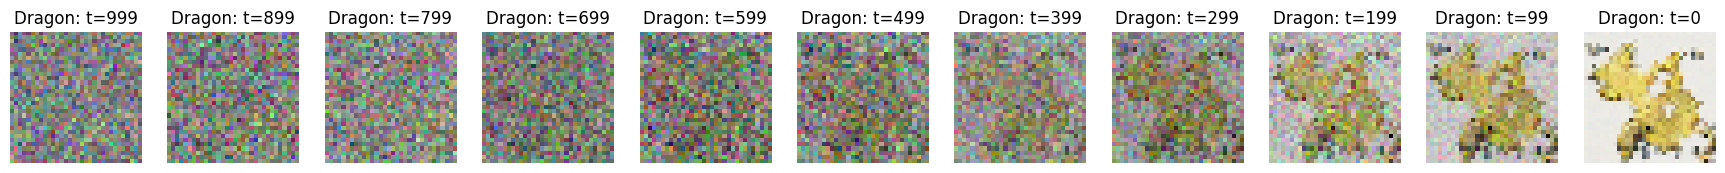

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.1917 - loss: 0.1036 - val_loss: 0.1125 - val_mae: 0.1992
Epoch 176/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1897 - loss: 0.1030 - val_loss: 0.0832 - val_mae: 0.1756
Epoch 177/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1909 - loss: 0.1031 - val_loss: 0.1141 - val_mae: 0.1984
Epoch 178/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1885 - loss: 0.0999 - val_loss: 0.1007 - val_mae: 0.1867
Epoch 179/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1885 - loss: 0.1007 - val_loss: 0.0954 - val_mae: 0.1827
Epoch 180/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1884 - loss: 0.1001 - val_loss: 0.1102 - val_mae: 0.1978
Epoch 181/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1902 - loss: 0.1015 - val_loss: 0.1099 - val_mae: 0.2023
Epoch 182/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1926 - loss: 0.1055 - val_loss: 0.1095 - val_mae: 0.2017
Epoch 183/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113m

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.73it/s]


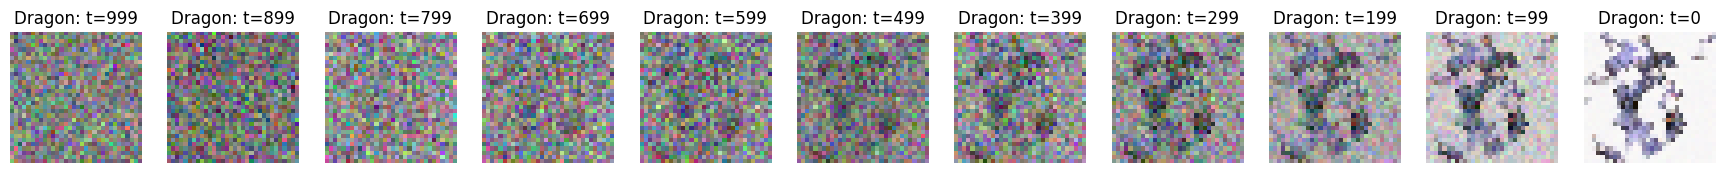

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1909 - loss: 0.1036 - val_loss: 0.1090 - val_mae: 0.1984
Epoch 201/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1882 - loss: 0.1017 - val_loss: 0.0910 - val_mae: 0.1775
Epoch 202/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1869 - loss: 0.1008 - val_loss: 0.1029 - val_mae: 0.1871
Epoch 203/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1863 - loss: 0.0989 - val_loss: 0.0944 - val_mae: 0.1810
Epoch 204/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1858 - loss: 0.0998 - val_loss: 0.1122 - val_mae: 0.1967
Epoch 205/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1879 - loss: 0.1004 - val_loss: 0.0908 - val_mae: 0.1806
Epoch 206/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1869 - loss: 0.1003 - val_loss: 0.0943 - val_mae: 0.1784
Epoch 207/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1883 - loss: 0.1022 - val_loss: 0.1070 - val_mae: 0.1934
Epoch 208/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113m

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.66it/s]


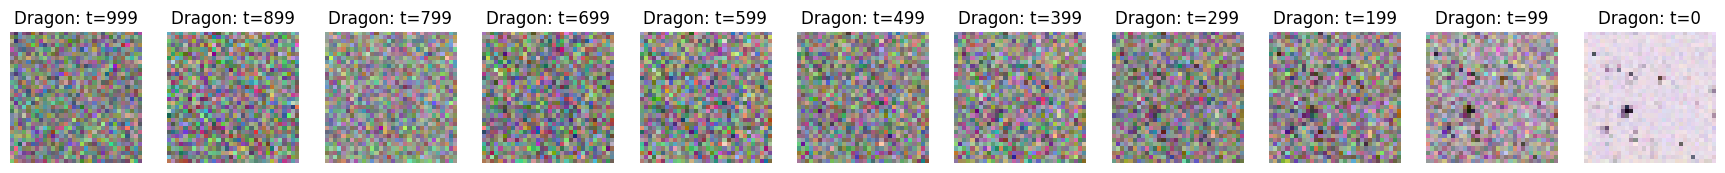

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1874 - loss: 0.1025 - val_loss: 0.1159 - val_mae: 0.2064
Epoch 226/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1853 - loss: 0.0991 - val_loss: 0.1213 - val_mae: 0.2099
Epoch 227/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1838 - loss: 0.0967 - val_loss: 0.1030 - val_mae: 0.1892
Epoch 228/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1833 - loss: 0.0976 - val_loss: 0.1073 - val_mae: 0.1952
Epoch 229/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1847 - loss: 0.1004 - val_loss: 0.0786 - val_mae: 0.1652
Epoch 230/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1843 - loss: 0.0981 - val_loss: 0.1080 - val_mae: 0.1955
Epoch 231/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1837 - loss: 0.0976 - val_loss: 0.1240 - val_mae: 0.2074
Epoch 232/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1826 - loss: 0.0971 - val_loss: 0.1036 - val_mae: 0.1909
Epoch 233/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113m

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.70it/s]


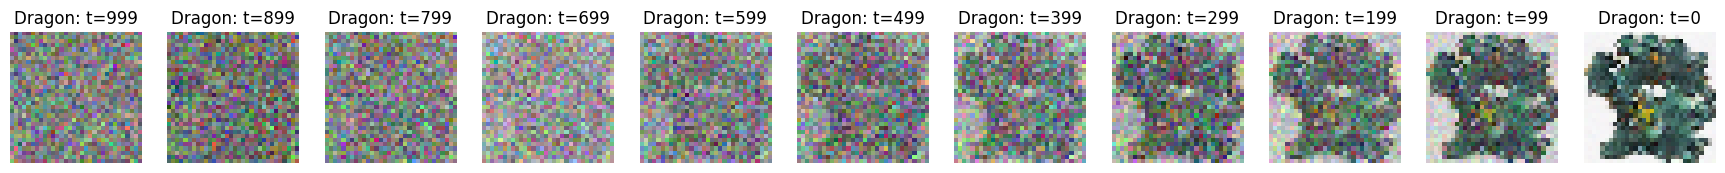

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1802 - loss: 0.0953 - val_loss: 0.1026 - val_mae: 0.1888
Epoch 251/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1804 - loss: 0.0967 - val_loss: 0.1022 - val_mae: 0.1880
Epoch 252/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1820 - loss: 0.0971 - val_loss: 0.1037 - val_mae: 0.1933
Epoch 253/500
11/30 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - mae: 0.1792 - loss: 0.0929

In [7]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 25, "Dragon")
history = model.fit(
    train_poke_dataset,
    epochs=EPOCHS,
    validation_data=test_poke_dataset,
    callbacks=[diff_callback],
)

## 2.2. Evaluación del modelo

Una vez entrenado el modelo, lo evaluamos gracias al conjunto de testeo que definimos anteriormente. Para evaluar el entrenamiento del modelo se mostrarán la evolución de los valores de la función de perdida y las métricas a lo largo del entrenamiento. Todo ello, para garantizar el correcto entrenamiento del modelo de difusión, evitando su overfitting principalmente.

Y tal y como podemos observar el modelo no sufre de overfitting y ambas funciones tienen a minimizar el error cometido correctamente, por lo que podemos garantizar que el entrenamiento se ha realizado con éxito.

In [ ]:
visualize.plot_history(history)

## 2.3. Resultados y guardado del modelo

Finalmente, una vez comprobado el correcto entrenamiento del modelo, procedemos a guardarlo para futuras síntesis de imágenes sin necesidad de estar entrenando de nuevo el modelo. Además, aprovechamos para mostrar la generación de imágenes tras el entrenamiento del modelo.

In [ ]:
# Save and load the model
# =====================================================================
save_path = f"{MODELS_PATH}/diffusion_{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}_epochs{EPOCHS}.weights.h5"
save_path = f"{MODELS_PATH}/beta5_test4_overfitting_0.2_ema_diffusion_{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}_epochs{EPOCHS}.weights.h5"
model.save_weights(save_path)

model_loaded = DiffusionModel.load_model(
    save_path,
    u_net,
    ema_u_net,
    IMG_SIZE,
    NUM_CLASSES,
    TIMESTEPS,
    BETA_START,
    BETA_END,
    S,
    SCHEDULER,
    ema=0.999
)

In [ ]:
# Sample some sprites
# =====================================================================
model_loaded.plot_samples(6)
model_loaded.plot_samples(6)
model_loaded.plot_samples(6)
model_loaded.plot_samples(6, "Fire")
model_loaded.plot_samples(6, "Water")
model_loaded.plot_samples(6, "Grass")

[BACK TO TOP](#top)